In [1]:
import numpy as npx
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import os

task_names = [
    "bernoulli_glm",
    # "gaussian_linear",
    "gaussian_linear_uniform",
    "gaussian_mixture",
    "two_moons",
]

values_dfs = {}
std_dfs = {}

for task_name in task_names:
    result_dir = os.path.join("results", task_name)
    values_dfs[task_name] = pd.read_csv(os.path.join(result_dir, "values.csv"), index_col=0)
    std_dfs[task_name] = pd.read_csv(os.path.join(result_dir, "std.csv"), index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'results/gaussian_linear_uniform/values.csv'

In [3]:
full_values = pd.concat(values_dfs)
full_stds = pd.concat(std_dfs)

In [4]:
print(full_values.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
                  column_format="c" * len(full_values.columns),
))

print(full_stds.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
                  column_format="c" * len(full_stds.columns)
))

\begin{tabular}{ccc}
\toprule
$\alpha$ & Nominal & CPO \\
\midrule
0.05 & -3.53 & -10.16 \\
\bottomrule
\end{tabular}

\begin{tabular}{ccc}
\toprule
$\alpha$ & Nominal & CPO \\
\midrule
0.05 & 3.14 & 13.86 \\
\bottomrule
\end{tabular}



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from rsome import ro
from rsome import grb_solver as grb
import rsome as rso
import numpy as np

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import sbibm

import os
import pickle

In [6]:
task_name = "slcp"

task = sbibm.get_task(task_name)
prior = task.get_prior_dist()
simulator = task.get_simulator()

In [12]:
device = "cuda:0"
cached_fn = os.path.join("trained", f"{task_name}.nf")
with open(cached_fn, "rb") as f:
    encoder = pickle.load(f)
encoder.to(device)

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=10, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer): Linear(in_features=8, out_features=50, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): Linear(in_features=50, out_features=87, bias=True)
        )
      )
      (1): LULinear()
      (2): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=11, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer

In [18]:
c = prior.sample((10,))
x = simulator(c).to(device)
c = c.to(device)

In [25]:
encoder.sample(5, x)

tensor([[[-4.5319e-01,  1.5772e-01, -1.2418e+00,  2.1076e+00,  2.3707e+00],
         [-7.1272e-01,  2.8112e+00, -1.3999e+00,  1.4454e+00,  2.3881e+00],
         [-3.9279e-01,  2.5735e+00,  1.2463e+00, -1.6984e+00,  1.2985e+00],
         [-9.2170e-01,  1.4552e+00, -1.6368e+00,  1.8967e+00,  2.0997e+00],
         [-2.4356e+00,  1.2336e+00, -1.4954e+00, -1.6659e+00,  1.7538e+00]],

        [[-5.5357e-01,  2.4265e-02, -1.8028e+00,  2.6282e+00,  1.9291e+00],
         [-2.3763e+00,  7.6003e-03,  1.9184e+00, -3.0059e+00,  1.8025e+00],
         [-3.5926e-01,  2.2549e+00,  2.5962e+00, -2.3844e+00,  1.2497e+00],
         [ 1.0904e+00,  3.0178e+00,  1.7545e+00, -3.0406e+00,  2.1776e+00],
         [-7.8171e-01,  1.9912e+00, -1.7818e+00, -2.6858e+00,  2.8235e+00]],

        [[-2.4810e+00, -9.6669e-01, -1.1110e+00,  2.8203e-01, -1.0277e+00],
         [-1.1957e+00, -7.8689e-01, -2.6782e+00,  1.2707e-01,  2.1655e+00],
         [ 8.0618e-01, -9.1244e-01, -2.6276e+00, -2.5432e-01,  1.3139e+00],
        

In [3]:
def reject_outliers(X, m = 2):
    d = np.abs(X - np.median(X))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return X[s<m]

In [5]:
full_dfs = []
for task_idx, task_name in enumerate(task_names):
    dfs = []
    baseline_fn = os.path.join("results", task_name, f"Nominal.csv")
    baseline_df = pd.read_csv(baseline_fn, index_col=0)
    for method_name in method_names:
        fn = os.path.join("results", task_name, f"{method_name}.csv")
        method_df = pd.read_csv(fn, index_col=0)
        zeroed_df = method_df - baseline_df
        dfs.append(zeroed_df)

    df = pd.concat(dfs).T
    df.columns = method_names
    df["E"] = task_idx
    full_dfs.append(df)
full_df = pd.concat(full_dfs)

In [3]:
import os
import pandas as pd
import numpy as np

In [39]:
method_names = ["Box", "PTC-B", "Ellipsoid", "PTC-E", "CPO", "Nominal"]
task_names = os.listdir("results")

task_name_to_mean = {}
task_name_to_std = {}
for task_name in task_names:
    baseline_fn = os.path.join("results", task_name, f"Nominal.csv")
    baseline_df = pd.read_csv(baseline_fn, index_col=0)
    baseline_values = baseline_df.values[0]

    means = []
    stds = []
    for method_name in method_names:
        fn = os.path.join("results", task_name, f"{method_name}.csv")
        df = pd.read_csv(fn, index_col=0)
        
        values = df.values[0] - baseline_values
        values = values[np.where(baseline_values != 0)] 
        
        means.append(np.mean(values))
        stds.append(np.std(values))
    task_name_to_mean[task_name] = means
    task_name_to_std[task_name] = stds
task_name_to_mean_df = pd.DataFrame(task_name_to_mean, index=method_names).T
task_name_to_std_df = pd.DataFrame(task_name_to_std, index=method_names).T


In [40]:
fmt_df = task_name_to_mean_df.round(2).astype(str).add(' (').add(task_name_to_std_df.round(2).astype(str)).add(')')
fmt_df["CPO"] = r"\textbf{" + fmt_df["CPO"] + "}"
fmt_df["Nominal"] = r"\textit{" + fmt_df["Nominal"] + "}"

In [41]:
print(fmt_df.to_latex(index=False, escape=False,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
                  column_format="c" * len(task_name_to_mean_df),
))

\begin{tabular}{cccccc}
\toprule
        Box &       PTC-B &   Ellipsoid &       PTC-E &                  CPO &            Nominal \\
\midrule
0.22 (0.12) &  0.3 (0.08) & 0.31 (0.11) & 0.27 (0.07) & \textbf{0.14 (0.05)} & \textit{0.0 (0.0)} \\
 0.6 (0.42) &  0.6 (0.42) &  0.6 (0.42) &  0.6 (0.42) & \textbf{0.54 (0.46)} & \textit{0.0 (0.0)} \\
2.22 (1.27) & 2.22 (1.27) & 2.22 (1.27) & 2.15 (1.18) & \textbf{2.12 (1.11)} & \textit{0.0 (0.0)} \\
1.81 (0.95) &  2.1 (0.91) &  2.3 (0.98) & 2.07 (0.68) & \textbf{1.37 (0.62)} & \textit{0.0 (0.0)} \\
4.64 (3.12) & 4.19 (2.85) & 4.64 (3.12) & 4.48 (2.91) & \textbf{3.57 (1.94)} & \textit{0.0 (0.0)} \\
 4.4 (2.75) &  2.1 (1.06) &  4.4 (2.75) & 1.66 (1.07) & \textbf{1.26 (0.69)} & \textit{0.0 (0.0)} \\
\bottomrule
\end{tabular}



In [26]:
print(task_name_to_std_df.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
                  column_format="c" * len(task_name_to_std_df),
))

\begin{tabular}{cccccc}
\toprule
 & Box & PTC-B & Ellipsoid & PTC-E & CPO & Nominal \\
\midrule
sir & 0.02 & 0.02 & 0.00 & 0.03 & 0.13 & 0.09 \\
two_moons & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.16 \\
gaussian_linear_uniform & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.35 \\
lotka_volterra & 0.01 & 0.45 & 0.00 & 0.03 & 0.69 & 0.57 \\
bernoulli_glm & 0.00 & 0.84 & 0.00 & 0.00 & 0.00 & 2.17 \\
gaussian_mixture & 0.00 & 2.10 & 0.00 & 0.60 & 0.00 & 0.55 \\
\bottomrule
\end{tabular}



In [4]:
task_names = os.listdir("results")

task_name_to_value = {}
for task_name in task_names:
    fn = os.path.join("results", task_name, f"coverage.csv")
    df = pd.read_csv(fn, index_col=0)
    task_name_to_value[task_name] = df.values[0]

FileNotFoundError: [Errno 2] No such file or directory: 'results/sir/coverage.csv'

In [60]:
task_name_to_value_df = pd.DataFrame(task_name_to_value, index=[r"$\alpha$", "Box", "PTC-B", "Ellipsoid", "PTC-E", "CPO"]).T
print(task_name_to_value_df.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
                  column_format="c" * len(task_name_to_value),
))

\begin{tabular}{ccccccccc}
\toprule
 & $\alpha$ & Box & PTC-B & Ellipsoid & PTC-E & CPO \\
\midrule
sir & 0.05 & 0.94 & 0.95 & 0.93 & 0.95 & 0.93 \\
two_moons & 0.05 & 0.93 & 0.94 & 0.94 & 0.94 & 0.96 \\
slcp & 0.05 & 0.93 & 0.95 & 0.95 & 0.95 & 0.94 \\
gaussian_linear_uniform & 0.05 & 0.94 & 0.96 & 0.95 & 0.95 & 0.95 \\
slcp_distractors & 0.05 & 0.95 & 0.95 & 0.93 & 0.95 & 0.93 \\
lotka_volterra & 0.05 & 0.95 & 0.96 & 0.94 & 0.94 & 0.95 \\
bernoulli_glm & 0.05 & 0.96 & 0.95 & 0.95 & 0.94 & 0.94 \\
gaussian_mixture & 0.05 & 0.95 & 0.93 & 0.94 & 0.93 & 0.94 \\
gaussian_linear & 0.05 & 0.95 & 0.95 & 0.95 & 0.94 & 0.95 \\
\bottomrule
\end{tabular}



In [8]:
c_dataset = np.zeros((3, 3))

In [36]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [46]:
df = pd.DataFrame(reference_samples, columns=[f"$\\theta_{i}$" for i in range(reference_samples.shape[-1])])

In [16]:
import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
import sbibm
import seaborn as sns

plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

task_name = "lotka_volterra"
task = sbibm.get_task(task_name)
prior = task.get_prior_dist()
simulator = task.get_simulator()
observation = task.get_observation(num_observation=1)  # 10 per task

device = "cuda:0"
cached_fn = os.path.join("trained", f"{task_name}.nf")
with open(cached_fn, "rb") as f:
    encoder = pickle.load(f)
encoder.to(device)

# n_var_samples = 10_000
# reference_samples = task.get_reference_posterior_samples(num_observation=1)
# variational_samples = encoder.sample(n_var_samples, observation.to(device))

# column_names = [f"$\\theta_{i}$" for i in range(reference_samples.shape[-1])]
# reference_df = pd.DataFrame(reference_samples, columns=column_names)
# variational_df = pd.DataFrame(variational_samples.detach().cpu().numpy()[0], columns=column_names)

/home/yppatel/anaconda3/envs/chig/lib/python3.8/site-packages/diffeqtorch/diffeqtorch.py:29: UserWarning: JULIA_SYSIMAGE_DIFFEQTORCH not set
  warn("JULIA_SYSIMAGE_DIFFEQTORCH not set")
/home/yppatel/anaconda3/envs/chig/lib/python3.8/site-packages/diffeqtorch/diffeqtorch.py:32: UserWarning: Defaulting to /home/yppatel/.julia_sysimage_diffeqtorch.so
  warn(f"Defaulting to {default_path}")


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=22, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer): Linear(in_features=20, out_features=50, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): Linear(in_features=50, out_features=58, bias=True)
        )
      )
      (1): LULinear()
      (2): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=22, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_laye

In [17]:
import numpy as np

alpha = 0.05

c_cal = prior.sample((100,))
x_cal = simulator(c_cal)

conformal_quantiles = []
for k in range(1, 100):
    c_cal_hat = encoder.sample(k, x_cal.to(device)).detach().cpu().numpy()
    c_cal_tiled = np.transpose(np.tile(c_cal.detach().cpu().numpy(), (k, 1, 1)), (1, 0, 2))
    c_cal_diff = c_cal_hat - c_cal_tiled
    c_cal_norms = np.linalg.norm(c_cal_diff, axis=-1)
    c_cal_scores = np.min(c_cal_norms, axis=-1)

    conformal_quantile = np.quantile(c_cal_scores, q = 1 - alpha)
    conformal_quantiles.append(conformal_quantile)

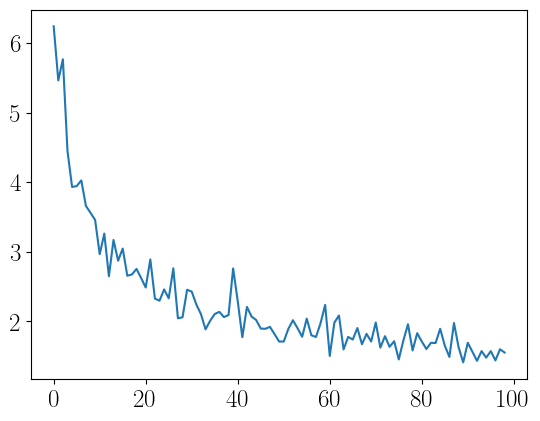

In [ ]:
plt.plot(conformal_quantiles)

In [49]:
reference_df["src"] = "reference"
variational_df["src"] = "inference"
df = pd.concat([reference_df, variational_df])

In [52]:
df = pd.concat([reference_df, variational_df])

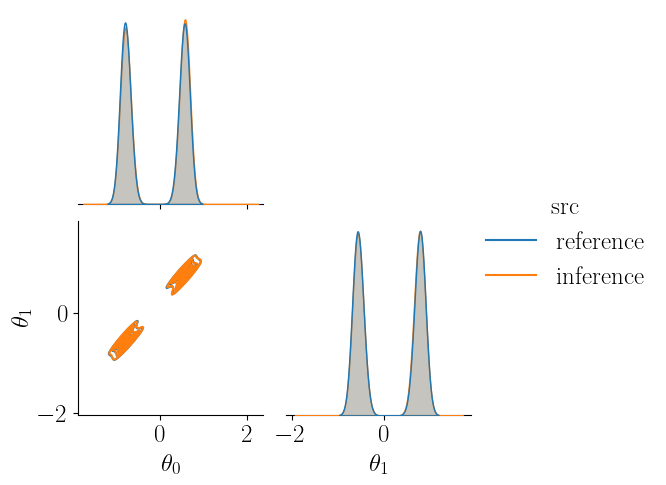

In [55]:

g_ref = sns.pairplot(df, kind="kde", corner=True, hue="src")
dir_name = "posteriors"
plt.savefig(os.path.join(dir_name, f"{task_name}.png"))

In [58]:
sorted([x.split(".")[0] for x in os.listdir("trained")])

['bernoulli_glm',
 'gaussian_linear',
 'gaussian_linear_uniform',
 'gaussian_mixture',
 'lotka_volterra',
 'sir',
 'slcp',
 'slcp_distractors',
 'two_moons']